# Segmentazione di edifici da immagini satellitari e classificazione del contesto urbano: notebook per classificazione di immagini

*Progetto di Visione Artificiale e Riconoscimento 2024/2025*

- **Nome:** Pablo Sebastian
- **Cognome:** Vargas Grateron
- **Email:** pablo.vargasgrateron@studio.unibo.it

Questo progetto si concentra sulla segmentazione di edifici da immagini satellitari e sulla classificazione del contesto urbano. Utilizza tecniche di deep learning per analizzare immagini aeree e identificare edifici e altre strutture urbane.

Il dataset utilizzato è il dataset [Inria Aerial Image Labeling](https://project.inria.fr/aerialimagelabeling/), che contiene immagini aeree ad alta risoluzione e le relative maschere di segmentazione degli edifici.

> Assicurati di scaricare il dataset prima di eseguire il notebook e di avere al meno 50 GB di spazio libero su disco.

## Librerie e percorsi dei dataset

Il codice contenuto nelle seguenti celle importa le librerie necessarie e definisce i percorsi per i dataset utilizzati nel progetto.

> Assicurati di avere installato le librerie richieste contenute nel file `requirements.txt` prima di eseguire il notebook.

In [1]:
import os, time, random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
from scipy import ndimage
from scipy.spatial import distance, distance_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Per la prossima cella, assicurati di avere i seguenti percorsi impostati correttamente:
- `PATH_DATASET_DIR`: percorso alla cartella principale dove sono memorizzati i dataset.
- `PATH_DATASET`: percorso alla cartella contenente i dataset originali.
- `PATH_PROCESSED_DATASET`: percorso alla cartella dove saranno memorizzati i dataset elaborati.
- `PATH_MODEL`: percorso alla cartella dove sarà memorizzato il modello addestrato.

In [2]:
PATH_DATASET_DIR = Path("../../dataset")
PATH_PROCESSED_DATASET = PATH_DATASET_DIR / "processed"

PATH_TRAIN_DATASET_PROCESSED = PATH_PROCESSED_DATASET / "train"
PATH_TEST_DATASET_PROCESSED = PATH_PROCESSED_DATASET / "test"

PATH_MODEL = Path("model") / "UnetWSatellite.keras"

## Setup: caricamento del modello e processing delle immagini

Per utilizzare il modello addestrato, è necessario caricarlo e preparare le immagini per la classificazione. Nella seguente cella, eseguiamo queste operazioni.

> Per procedere, assicurati di avere il modello addestrato nel primo notebook `1_model_training.ipynb`.

In [6]:
JACCARD_INDEX_SMOOTH = 1e-12

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + JACCARD_INDEX_SMOOTH) / (sum_ - intersection + JACCARD_INDEX_SMOOTH)
    return K.mean(jac)

In [10]:
dependencies = {'jaccard_index': jaccard_index}
loaded_model=keras.models.load_model(PATH_MODEL, custom_objects=dependencies)

### Individuazione della soglia binaria per la segmentazione

Prima di classificare le immagini, è importante trovare la soglia ottimale per la segmentazione. Questa soglia può essere trovata utilizzando la funzione `find_best_threshold_from_paths` definita nella seguente cella. Questa funzione esegue una ricerca della soglia ottimale su un campione di immagini e maschere.

> **ATTENZIONE:** L'analisi prevede l'uso intensivo del modello, quindi è consigliabile eseguire questa operazione su un campione ridotto di dati per risparmiare tempo e risorse o utilizzare un ambiente di calcolo più potente.

In [11]:
def find_best_threshold_from_paths(model, images_path, masks_path, sample_ratio=0.1, thresholds=np.arange(0.1, 1.0, 0.05), batch_size=32):

    image_files = sorted(list(images_path.glob("*.png")))
    mask_files = sorted(list(masks_path.glob("*.png")))

    if sample_ratio < 1.0:
        sample_size = int(len(image_files) * sample_ratio)
        sample_indices = random.sample(range(len(image_files)), sample_size)
        image_files = [image_files[i] for i in sample_indices]
        mask_files = [mask_files[i] for i in sample_indices]

    threshold_scores = {t: [] for t in thresholds}

    print(f"Analisi di {len(image_files)} immagini per trovare la soglia ottimale...")

    for i in range(0, len(image_files), batch_size):
        batch_image_files = image_files[i:i + batch_size]
        batch_mask_files = mask_files[i:i + batch_size]

        batch_images = []
        batch_masks = []
        valid_batch_indices = []

        for j, (img_path, mask_path) in enumerate(zip(batch_image_files, batch_mask_files)):
            try:
                image = np.array(Image.open(img_path).convert("RGB")) / 255.0
                mask = np.array(Image.open(mask_path).convert("L")) / 255.0
                mask = mask.astype(np.float32)

                batch_images.append(image)
                batch_masks.append(mask)
                valid_batch_indices.append(j)

            except Exception as e:
                print(f"Errore durante il caricamento di {img_path.name}: {e}")
                continue

        if not batch_images:
            continue

        batch_images = np.array(batch_images)
        batch_masks = np.array(batch_masks)


        try:
            predictions = model.predict(batch_images)

            for k, original_index in enumerate(valid_batch_indices):
                 prediction = predictions[k]

                 mask = batch_masks[k]

                 for t in thresholds:
                    binary_pred = (prediction > t).astype(np.float32)
                    if binary_pred.shape != mask.shape:
                        binary_pred = np.squeeze(binary_pred)

                    if binary_pred.shape == mask.shape:
                         score = jaccard_index(np.expand_dims(mask, axis=-1), np.expand_dims(binary_pred, axis=-1)).numpy()
                         threshold_scores[t].append(score)
                    else:
                        print(f"Shape mismatch: prediction {binary_pred.shape}, mask {mask.shape} for {batch_image_files[original_index].name}. Skipping.")


        except Exception as e:
            print(f"Errore durante la predizione o il calcolo dello score per il batch a partire da {batch_image_files[0].name}: {e}")
            continue


    average_scores = {t: np.mean(scores) if scores else 0 for t, scores in threshold_scores.items()}
    best_threshold = max(average_scores, key=average_scores.get) if average_scores else 0.5
    best_jaccard = average_scores.get(best_threshold, 0)

    return best_threshold, best_jaccard

In [12]:
best_th, best_jaccard = find_best_threshold_from_paths(
    loaded_model,
    PATH_TRAIN_DATASET_PROCESSED / "images",
    PATH_TRAIN_DATASET_PROCESSED / "gt",
    sample_ratio=0.1
)

Analisi di 1800 immagini per trovare la soglia ottimale...
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━

In [13]:
print("Best threshold:", best_th)
print("Best jaccard index:", best_jaccard)

Best threshold: 0.6000000000000002
Best jaccard index: 0.76137996


Adesso che abbiamo la soglia ottimale, possiamo utilizzarla per segmentare le immagini nel nostro set di dati. Utilizzeremo la funzione `segment_images_with_threshold` per applicare la soglia e ottenere le maschere segmentate.

In [ ]:
def segment_image_with_threshold(image_path, model, threshold):
    image = np.array(Image.open(image_path).convert("RGB"))
    prediction = model.predict(np.expand_dims(image, axis=0))
    binary_prediction = (prediction > threshold).astype(np.float32)
    return binary_prediction

## Classificatore delle maschere

Per la classificazione di questo progetto, useremo un approccio euristico basato su alcune caratteristiche estratte dalle maschere. Le caratteristiche considerate includono:

1. **Densità di occupazione**: La proporzione di pixel attivi nella maschera.
2. **Numero di oggetti**: Il numero di componenti connessi identificati nella maschera.
3. **Distanza media tra gli oggetti**: La distanza media tra i centroidi degli oggetti identificati.

Utilizzeremo queste caratteristiche per classificare ogni tile come "urbano" o "rurale" in base a soglie predefinite.

In [26]:
def feature_extraction(mask):
    mask = (mask > 0).astype(np.uint8)

    density = np.sum(mask) / mask.size
    labeled, num_obj = ndimage.label(mask)
    centroids = []
    for i in range(1, num_obj+1):
        coords = np.argwhere(labeled == i)
        if coords.size > 0:
            centroids.append(coords.mean(axis=0))

    nearest_neighbor_distance = 0
    if len(centroids) > 1:
        DM = distance_matrix(centroids, centroids)
        np.fill_diagonal(DM, np.inf)
        nearest_distances = DM.min(axis=1)
        nearest_neighbor_distance = np.mean(nearest_distances)

    return density, num_obj, nearest_neighbor_distance

Prima di determinare le soglie per la classificazione, è importante analizzare un campione rappresentativo di maschere e le loro caratteristiche estratte. Questo ci permetterà di stabilire soglie che siano adeguate e significative per il nostro dataset.

Useremo il training set per analizzare le caratteristiche delle maschere e definire le soglie.

In [28]:
def analyze_feature_statistics(masks_path, sample_ratio=0.1):

    mask_files = sorted(list(masks_path.glob("*.png")))

    if sample_ratio < 1.0:
        sample_size = int(len(mask_files) * sample_ratio)
        sample_indices = random.sample(range(len(mask_files)), sample_size)
        mask_files = [mask_files[i] for i in sample_indices]

    densities = []
    num_objs = []
    avg_distances = []

    print(f"Analisi delle statistiche delle feature per {len(mask_files)} maschere...")

    for mask_file in mask_files:
        try:
            mask = np.array(Image.open(mask_file).convert("L")) / 255.0
            mask = mask.astype(np.float32)

            density, num_obj, average_distance_obj = feature_extraction(mask)

            densities.append(density)
            num_objs.append(num_obj)
            avg_distances.append(average_distance_obj)

        except Exception as e:
            print(f"Errore durante il caricamento o l'estrazione delle feature per {mask_file.name}: {e}")
            continue

    # Plotting the statistics
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.hist(densities, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribuzione della Densità')
    plt.xlabel('Densità')
    plt.ylabel('Frequenza')

    plt.subplot(1, 3, 2)
    plt.hist(num_objs, bins=50, color='lightcoral', edgecolor='black')
    plt.title('Distribuzione del Numero di Oggetti')
    plt.xlabel('Numero di Oggetti')
    plt.ylabel('Frequenza')
    plt.yscale('log')

    plt.subplot(1, 3, 3)
    plt.hist(avg_distances, bins=50, color='lightgreen', edgecolor='black')
    plt.title('Distribuzione della Distanza Media tra gli Oggetti')
    plt.xlabel('Distanza Media')
    plt.ylabel('Frequenza')

    plt.tight_layout()
    plt.show()

    print("\nStatistiche riassuntive:")
    print(f"Densità: Media={np.mean(densities):.4f}, Mediana={np.median(densities):.4f}, Std={np.std(densities):.4f}, Min={np.min(densities):.4f}, Max={np.max(densities):.4f}")
    print(f"Numero di Oggetti: Media={np.mean(num_objs):.4f}, Mediana={np.median(num_objs):.4f}, Std={np.std(num_objs):.4f}, Min={np.min(num_objs):.4f}, Max={np.max(num_objs):.4f}")
    print(f"Distanza Media tra gli Oggetti: Media={np.mean(avg_distances):.4f}, Mediana={np.median(avg_distances):.4f}, Std={np.std(avg_distances):.4f}, Min={np.min(avg_distances):.4f}, Max={np.max(avg_distances):.4f}")

Analisi delle statistiche delle feature per 1800 maschere...


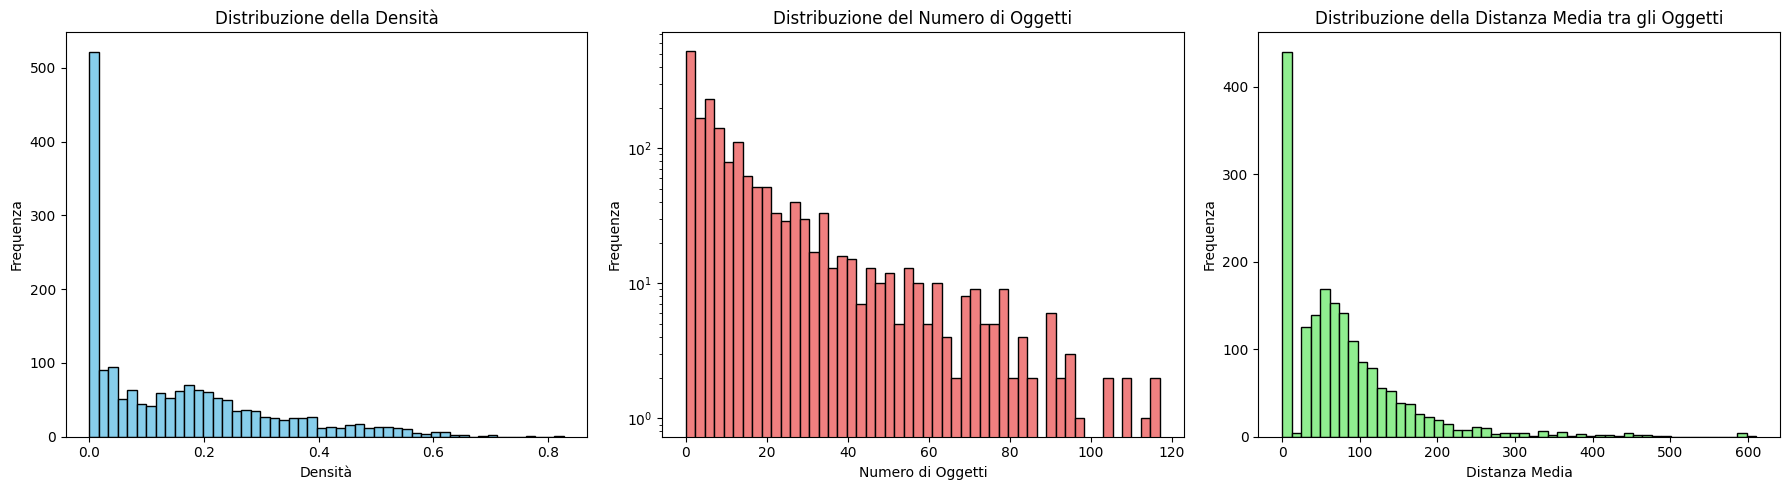


Statistiche riassuntive:
Densità: Media=0.1518, Mediana=0.1138, Std=0.1588, Min=0.0000, Max=0.8276
Numero di Oggetti: Media=14.1128, Mediana=7.0000, Std=19.0013, Min=0.0000, Max=117.0000
Distanza Media tra gli Oggetti: Media=78.1057, Mediana=62.8732, Std=81.5691, Min=0.0000, Max=610.5142


In [29]:
analyze_feature_statistics(PATH_TRAIN_DATASET_PROCESSED / "gt", sample_ratio=0.1)

Invece di determinare la soglia ottimale in forma approssimativa, possiamo utilizzare un approccio più rigoroso basato sull'analisi dei dati. In questo caso useremo un algoritmo di clustering con K-means per identificare la soglia ottimale.

L'algoritmo K-means ci permette di raggruppare i dati in cluster e di identificare i punti centrali di questi cluster. Applicando K-means ai valori delle predizioni del modello, possiamo trovare la soglia che separa le classi in modo ottimale.

In [31]:
def find_thresholds_with_kmeans(masks_path, sample_ratio=0.1):
    mask_files = sorted(list(masks_path.glob("*.png")))

    # Selezione campione
    if sample_ratio < 1.0:
        sample_size = int(len(mask_files) * sample_ratio)
        sample_indices = random.sample(range(len(mask_files)), sample_size)
        mask_files = [mask_files[i] for i in sample_indices]

    features = []
    print(f"Estrazione delle feature per K-Means da {len(mask_files)} maschere...")

    for mask_file in mask_files:
        try:
            mask = np.array(Image.open(mask_file).convert("L")) / 255.0
            mask = mask.astype(np.float32)

            density, num_obj, avg_distance = feature_extraction(mask)
            features.append([density, num_obj, avg_distance])

        except Exception as e:
            print(f"Errore durante il caricamento o l'estrazione delle feature per {mask_file.name}: {e}")
            continue

    if not features:
        print("Nessuna feature estratta. Impossibile eseguire K-Means.")
        return None

    # Normalizzazione per KMeans
    features = np.array(features)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Clustering
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
    kmeans.fit(scaled_features)
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    print("\nCentroidi dei cluster (feature originali):")
    for i, c in enumerate(centroids):
        print(f"Cluster {i}: Densità={c[0]:.4f}, Numero Oggetti={c[1]:.4f}, Distanza Media={c[2]:.4f}")

    # Identificazione euristica urbano/rurale
    if (centroids[0][0] + centroids[0][1]) < (centroids[1][0] + centroids[1][1]):
        rural_cluster_centroid = centroids[0]
        urban_cluster_centroid = centroids[1]
    else:
        rural_cluster_centroid = centroids[1]
        urban_cluster_centroid = centroids[0]

    print("\nCluster 'Rurale' (probabile): "
          f"Densità={rural_cluster_centroid[0]:.4f}, Numero Oggetti={rural_cluster_centroid[1]:.4f}, Distanza Media={rural_cluster_centroid[2]:.4f}")
    print("Cluster 'Urbano' (probabile): "
          f"Densità={urban_cluster_centroid[0]:.4f}, Numero Oggetti={urban_cluster_centroid[1]:.4f}, Distanza Media={urban_cluster_centroid[2]:.4f}")

    # Calcolo soglie come punto medio tra i due centroidi
    suggested_threshold_density = (rural_cluster_centroid[0] + urban_cluster_centroid[0]) / 2
    suggested_threshold_num_obj = (rural_cluster_centroid[1] + urban_cluster_centroid[1]) / 2
    suggested_threshold_distance = (rural_cluster_centroid[2] + urban_cluster_centroid[2]) / 2

    print("\nSoglie suggerite basate sui centroidi dei cluster:")
    print(f"  Densità: {suggested_threshold_density:.4f}")
    print(f"  Numero di Oggetti: {suggested_threshold_num_obj:.4f}")
    print(f"  Distanza Media tra gli Oggetti: {suggested_threshold_distance:.4f}")

    return suggested_threshold_density, suggested_threshold_num_obj, suggested_threshold_distance

In [32]:
suggested_thresholds = find_thresholds_with_kmeans(PATH_TRAIN_DATASET_PROCESSED / "gt", sample_ratio=0.2)

if suggested_thresholds:
    THRESHOLD_DENSITY, THRESHOLD_NUM_OBJ, THRESHOLD_DISTANCE = suggested_thresholds
    print("\nAggiornamento delle soglie globali con i valori suggeriti:")
    print(f"THRESHOLD_DENSITY = {THRESHOLD_DENSITY:.4f}")
    print(f"THRESHOLD_NUM_OBJ = {THRESHOLD_NUM_OBJ:.4f}")
    print(f"THRESHOLD_DISTANCE = {THRESHOLD_DISTANCE:.4f}")

Estrazione delle feature per K-Means da 3600 maschere...

Centroidi dei cluster (feature originali):
Cluster 0: Densità=0.0455, Numero Oggetti=4.8037, Distanza Media=73.1030
Cluster 1: Densità=0.3074, Numero Oggetti=27.7742, Distanza Media=80.6793

Cluster 'Rurale' (probabile): Densità=0.0455, Numero Oggetti=4.8037, Distanza Media=73.1030
Cluster 'Urbano' (probabile): Densità=0.3074, Numero Oggetti=27.7742, Distanza Media=80.6793

Soglie suggerite basate sui centroidi dei cluster:
  Densità: 0.1764
  Numero di Oggetti: 16.2890
  Distanza Media tra gli Oggetti: 76.8911

Aggiornamento delle soglie globali con i valori suggeriti:
THRESHOLD_DENSITY = 0.1764
THRESHOLD_NUM_OBJ = 16.2890
THRESHOLD_DISTANCE = 76.8911


## Classificazione del test set

Nella prima sezione del notebook abbiamo determinato la variabile `THRESHOLD_UNET` che rappresenta la soglia ottimale per la segmentazione delle immagini prodotte dal modello U-Net.

Nella seconda sezione, abbiamo utilizzato l'algoritmo K-means per identificare i cluster nei dati e abbiamo determinato le variabili:
- `THRESHOLD_DENSITY`: soglia ottimale per la segmentazione delle immagini basata sulla densità di pixel bianchi e neri.
- `THRESHOLD_NUM_OBJ`: soglia ottimale per la segmentazione delle immagini basata sul numero di oggetti rilevati dentro le maschere.
- `THRESHOLD_DISTANCE`: soglia ottimale per la segmentazione delle immagini basata sulla distanza tra ogni oggetto rilevato nelle maschere.


In [33]:
THRESHOLD_UNET = 0.6
THRESHOLD_DENSITY = 0.1832
THRESHOLD_NUM_OBJ = 16.6305
THRESHOLD_DISTANCE = 79.0774

Adesso possiamo utilizzare queste soglie per classificare le immagini in base alla loro segmentazione. Possiamo definire una funzione che prende un'immagine e restituisce la sua classe in base alle soglie definite.

L'approccio usato per la classificazione prevede un metodo basato a pesi, in cui ogni soglia contribuisce a determinare la classe finale dell'immagine con un certo peso.


In [ ]:
def euristic_classification(mask, th_density, th_num_obj, th_distance):
    density, num_obj, avg_dist = feature_extraction(mask)

    score = 0
    if density > th_density: score += 2
    if num_obj > th_num_obj: score += 1
    if avg_dist < th_distance: score += 1

    return "urbano" if score >= 2 else "rurale"

Finalmente, implementiamo la pipeline di classificazione delle immagini. Utilizzeremo le funzioni definite in precedenza per elaborare un insieme di maschere e ottenere le loro etichette di classe.

In [ ]:
def classify_mask(raw_mask, model=loaded_model):
    filtered_mask = segment_image_with_threshold(raw_mask, model, THRESHOLD_UNET)
    return euristic_classification(filtered_mask, THRESHOLD_DENSITY, THRESHOLD_NUM_OBJ, THRESHOLD_DISTANCE)

### Test della classificazione